In [3]:
#%%
import numpy as np
import pandas as pd
from sympy import im 
import torch 
import torch.nn 
import matplotlib.pyplot as plt
import warnings
from pd.nn.model import MLP

from pd.metric import amex_metric
from pd.data.loader import CustomerData, DataLoader
from pd.params import *
from pd.data.scaler import get_scaler



In [2]:
warnings.filterwarnings('ignore')

In [3]:
train_data = pd.read_parquet(DATADIR+"train_data.parquet")
train_labels = pd.read_csv(DATADIR+"train_labels.csv")
cont_cols = [col for col in train_data.columns.to_list() if col not in CATCOLS + ["customer_ID", "S_2", "target"]]


In [ ]:
test_data = pd.read_parquet(DATADIR+"test_data.parquet")


In [6]:
train_customers = train_data.customer_ID
test_customers = test_data.customer_ID


In [14]:
train_customers.value_counts()

0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a    13
a3111280bfa1ed8fafd0b06839eb707f4538497e8087cb62958bb03e1bdde214    13
a31376930229162f886c091e5a56a528f81c10a523285828ed05a6e9ccf56722    13
a312c595dfaee96c8a597107d2754a49b1acfd127400d98991762d87837b1b65    13
a312aff722e7230f9d6a313ff777d6f00166c6bada21a333982426758a2e2a9d    13
                                                                    ..
a84839802f1f37a86a7fe34ddba4791d33d878df3937b509841def0a9e252748     1
01f4f7b14d83b6a8f88e4355279224615da083b19e3e5f15b98f274ced8cf752     1
eef07ea56302cebcd57374c6565bb3e5c7af856796d9cbc31ed42aa0fc73b7fc     1
d192480082e86e3b4da68f014b284f2a2624b45956eed279416c796de043b7ce     1
d9ea3cffff889b522a69bde89aee382dcff8bffe32c9a38653bdaa2ff4330041     1
Name: customer_ID, Length: 458913, dtype: int64

In [8]:
set(train_customers).intersection(set(test_customers))


set()

In [13]:
for c in train_customers.values:
    if c in test_customers.values:
        break

In [41]:
s = pd.concat([train_customers.value_counts(), train_labels.set_index("customer_ID")], axis=1)

In [2]:
train_customers.value_counts().value_counts(normalize=True).cumsum()

NameError: name 'train_customers' is not defined

In [1]:
test_customers.value_counts().value_counts(normalize=True).cumsum()

NameError: name 'test_customers' is not defined

In [42]:
import seaborn as sns


In [18]:
train_customer_indices = train_customers.reset_index().set_index("customer_ID").groupby('customer_ID').apply(lambda x : x.to_numpy().reshape(-1, )).to_dict()



In [19]:
test_customer_indices = test_customers.reset_index().set_index("customer_ID").groupby('customer_ID').apply(lambda x : x.to_numpy().reshape(-1, )).to_dict()


In [20]:
c1 = train_labels[train_labels.target==1]
c1d = train_data[train_data.customer_ID.isin(c1.customer_ID)]

In [21]:
c0d = train_data[~train_data.customer_ID.isin(c1.customer_ID)]

In [25]:
c1d.groupby("customer_ID").count()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85,13,13,13,13,13,13,4,13,13,0,...,13,13,13,13,13,13,13,13,13,13
00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e4063bdf6b0f7d51eb6,13,13,13,13,13,13,3,13,13,0,...,13,13,13,13,13,13,0,13,13,13
0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba1730b2849b92ea687f9e,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
00013c6e1cec7c21bede7cb319f1e28eb994f5625257f479c53ad6e90c177f7c,13,13,13,13,13,13,13,13,13,8,...,13,13,13,13,13,12,0,13,13,13
0001812036f1558332e5c0880ecbad70b13a6f28ab04a8db6d83a26ef40aadb0,13,13,13,13,13,13,13,13,13,0,...,13,13,13,13,13,13,0,13,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe2bc02423407e33a607660caeed076d713d8a5ad32321530e92704835da88,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,7,0,8,7,8
fffe39594fad367d9eb8ae18537b56b0739c4cc3ab9810f8642d49ec45e60c62,13,13,13,13,13,13,13,13,13,0,...,13,13,13,13,13,12,0,13,13,13
fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731ade6e6a342e13184d3,13,13,13,13,13,13,11,13,13,4,...,13,13,13,13,13,13,0,13,13,13


# Q: Is there a relationsip between the length of each data point and their probability of deafult?
The number of data points of the pd differs for datapoints with lenght 13 and the rest of the data. The idea is to focus

In [22]:
train_data.columns

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=190)

# Analyze Csutomer target 1 data 

In [16]:
a = plt.hist(d, range=[q1, q2], bins=100, label=f"Zero_{len(d)}_{c}", density=True, alpha=0.5)


NameError: name 'd' is not defined

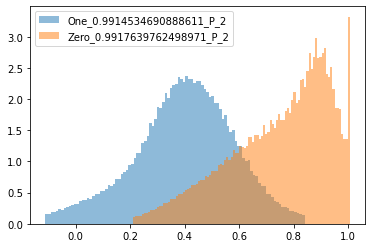

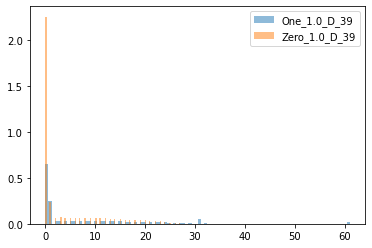

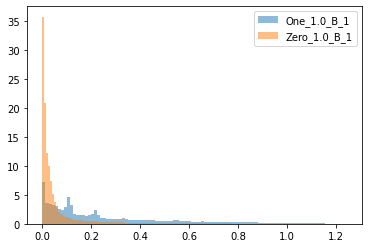

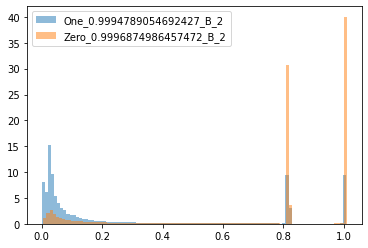

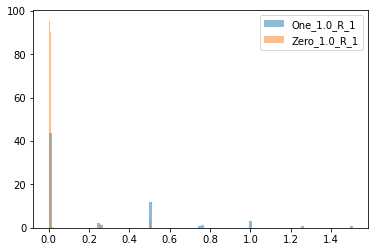

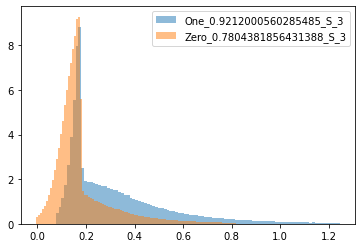

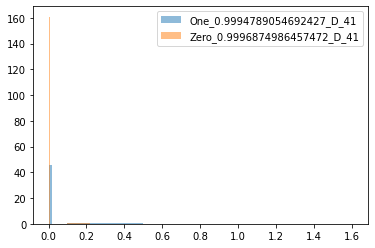

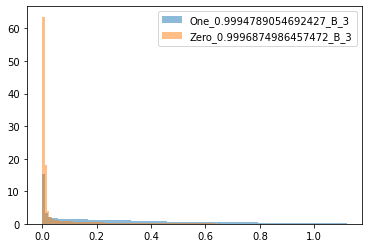

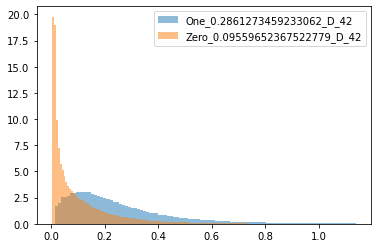

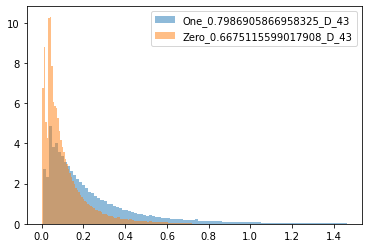

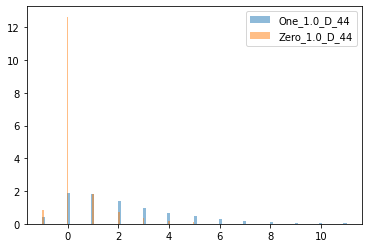

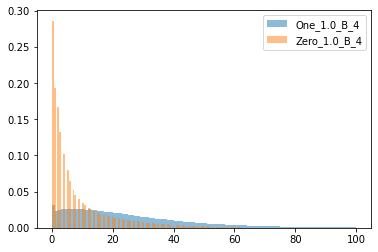

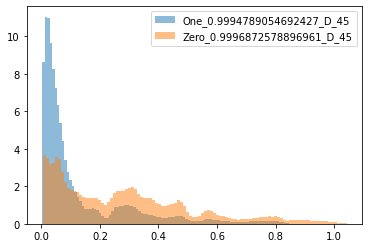

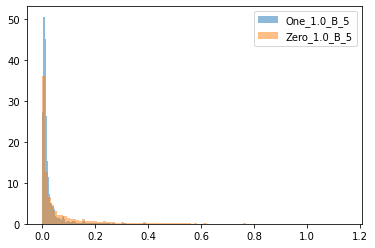

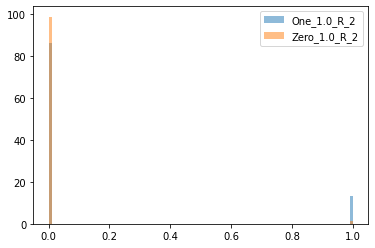

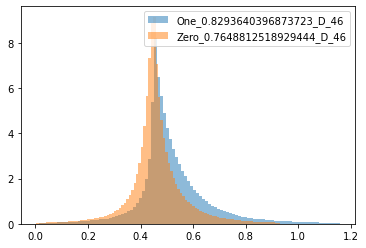

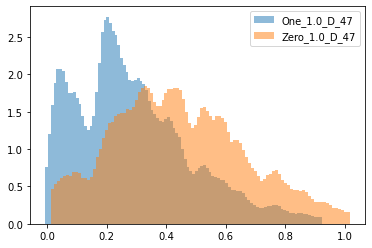

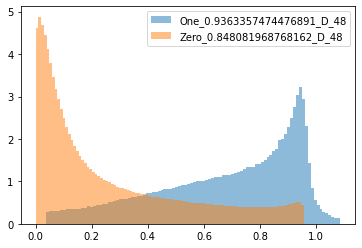

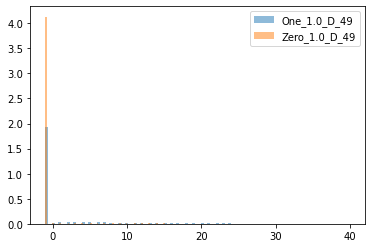

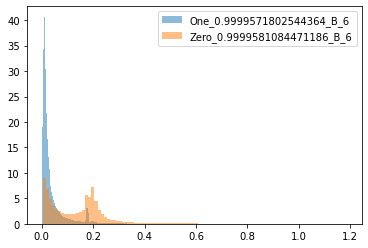

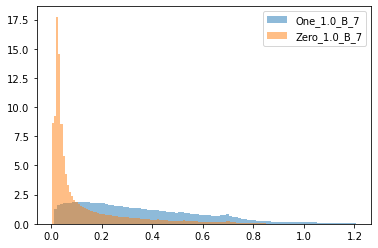

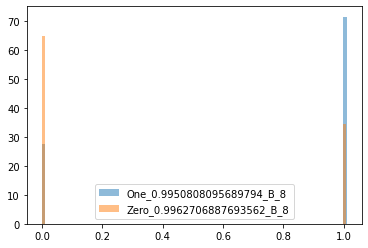

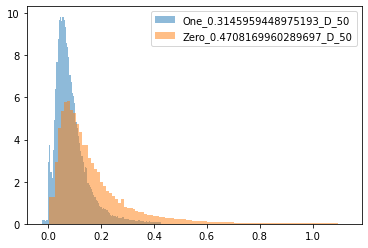

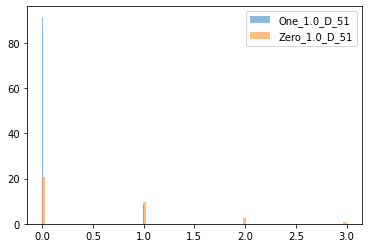

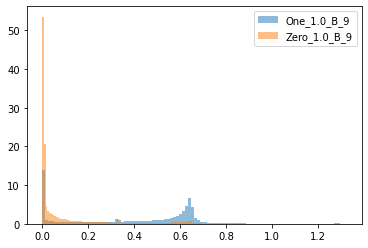

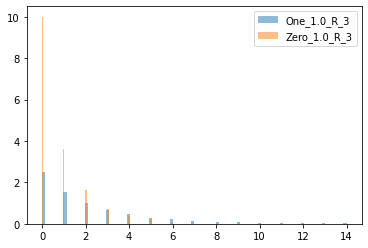

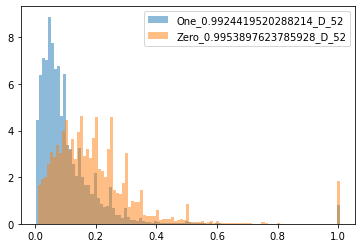

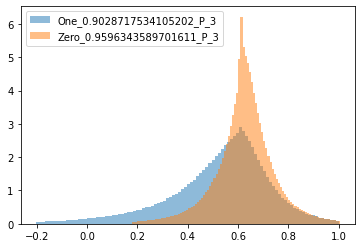

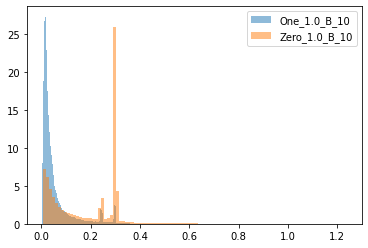

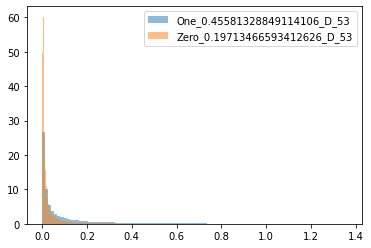

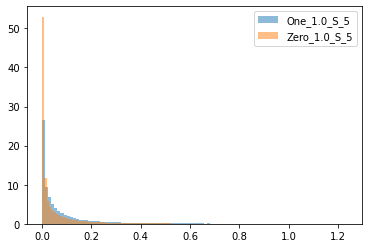

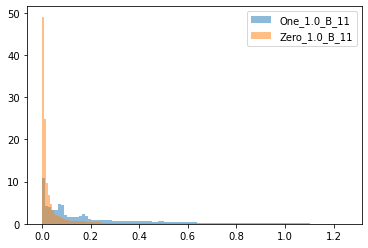

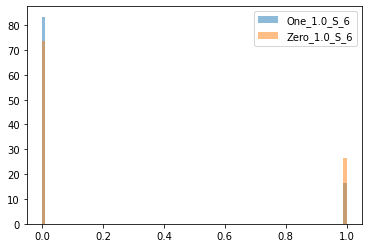

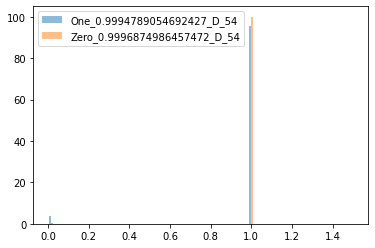

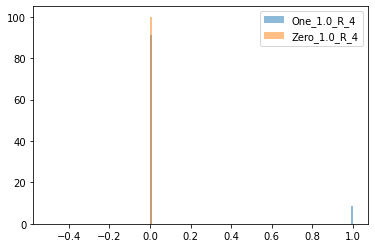

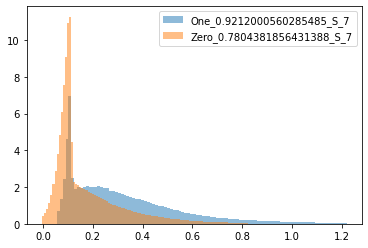

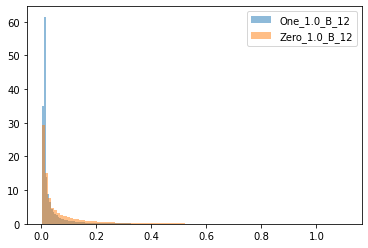

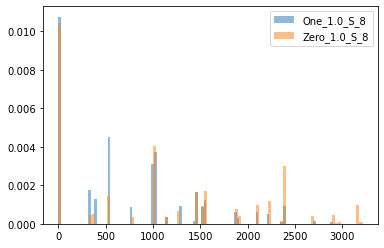

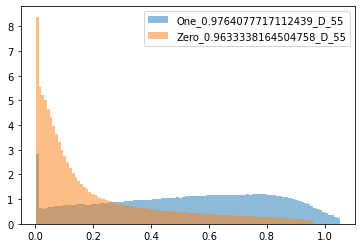

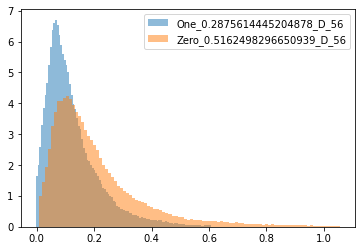

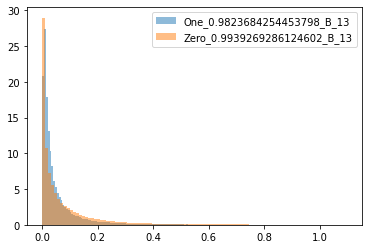

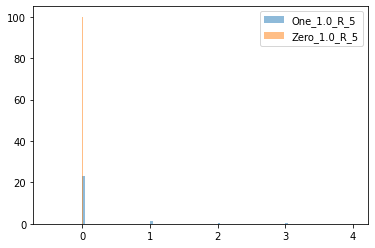

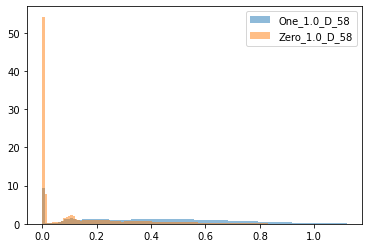

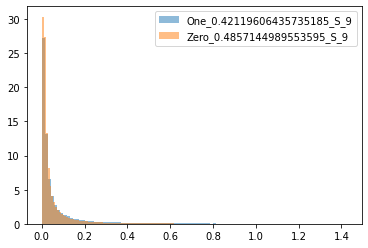

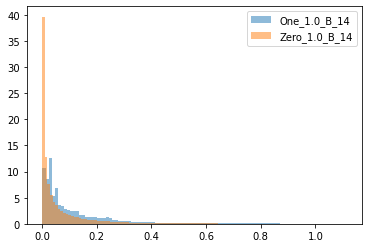

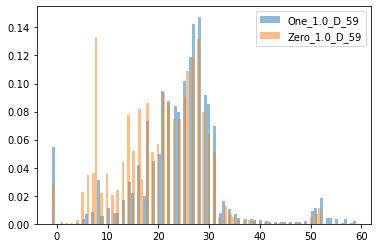

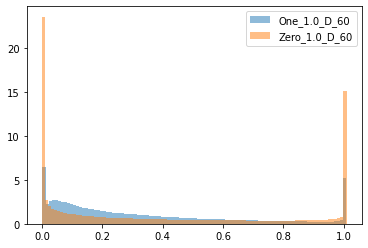

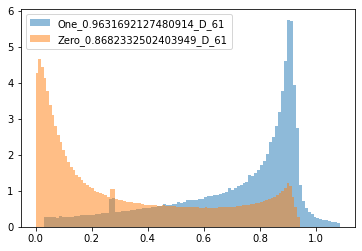

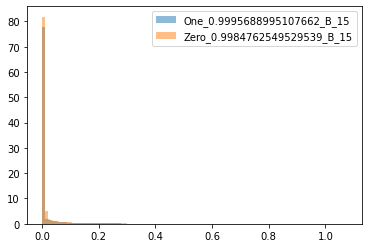

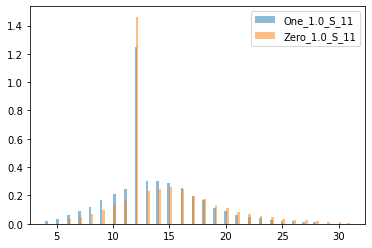

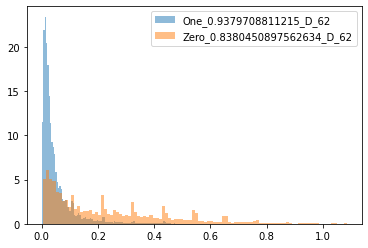

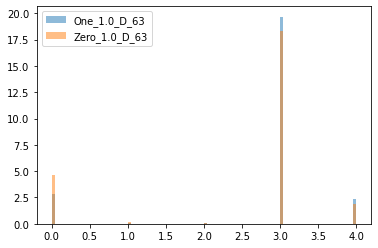

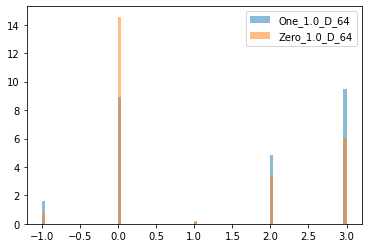

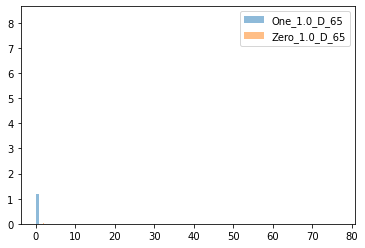

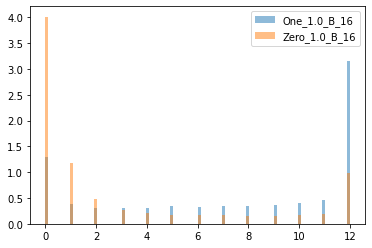

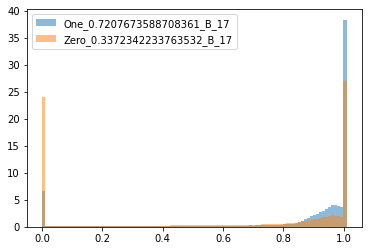

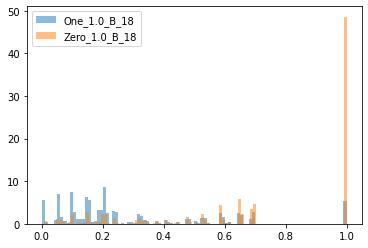

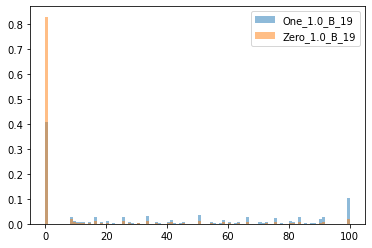

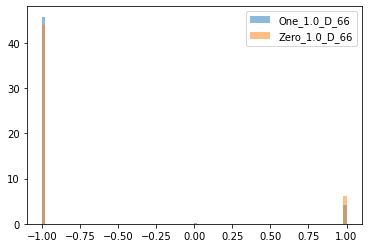

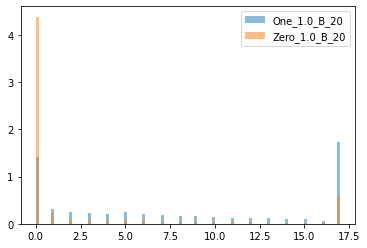

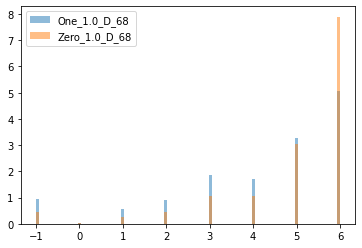

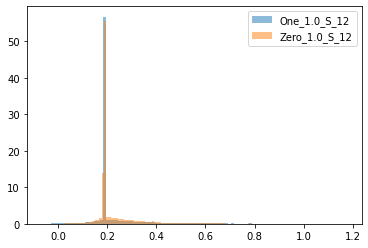

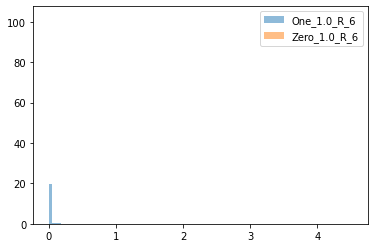

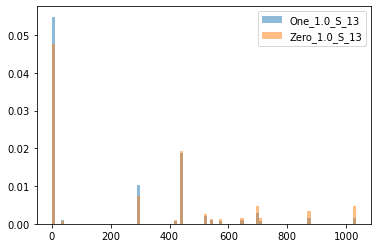

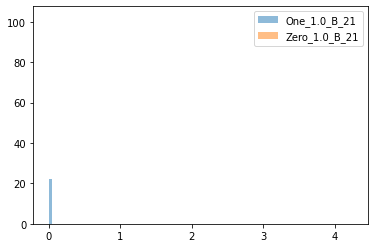

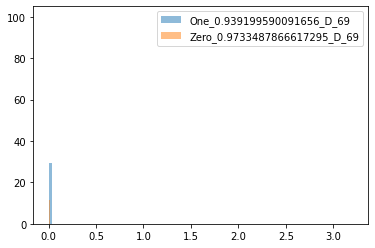

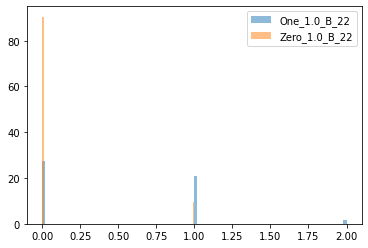

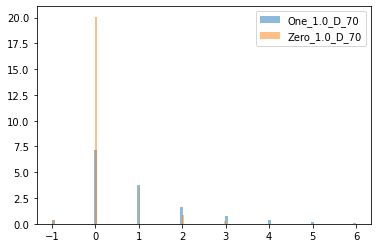

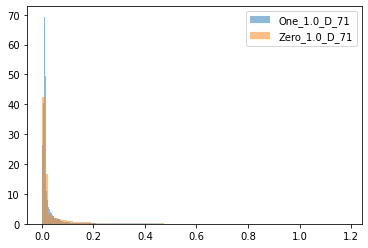

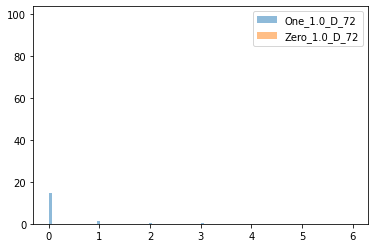

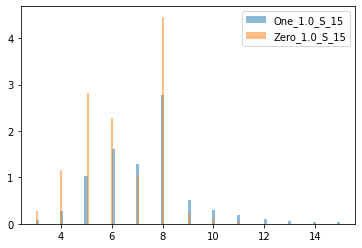

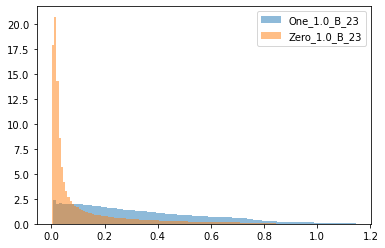

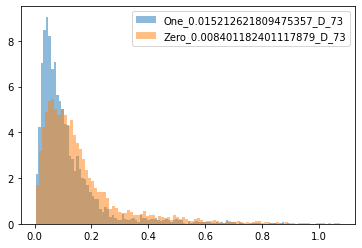

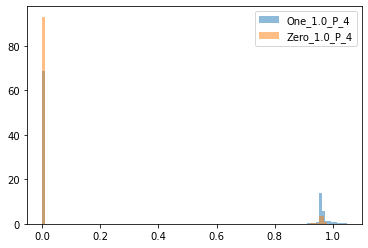

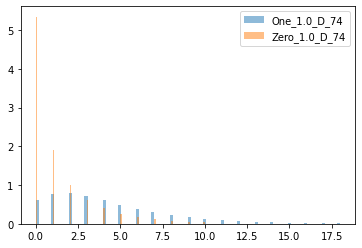

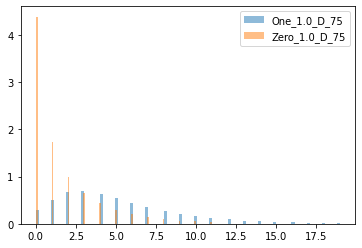

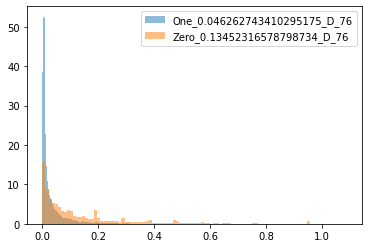

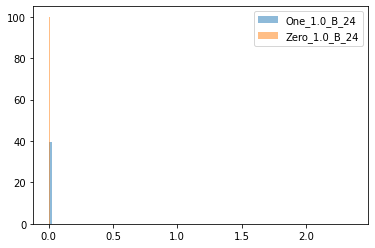

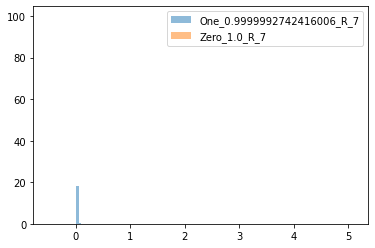

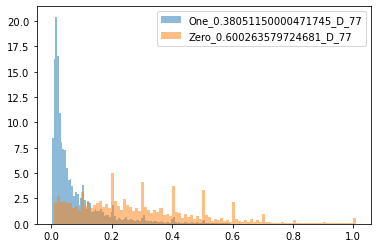

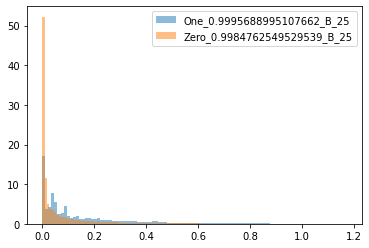

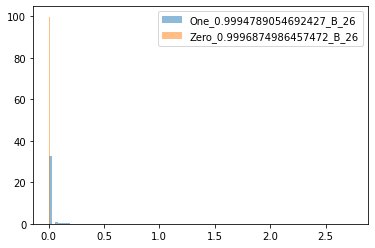

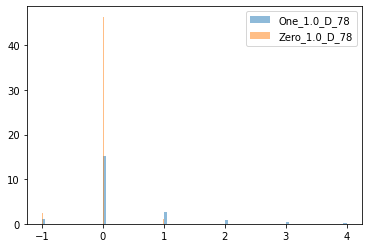

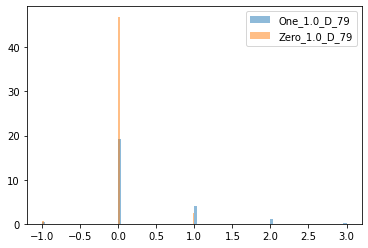

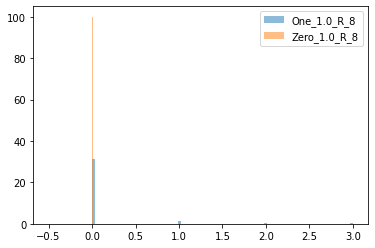

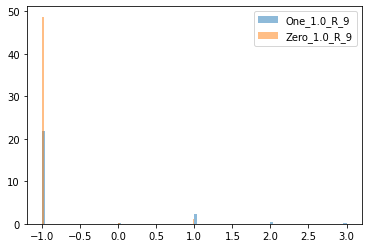

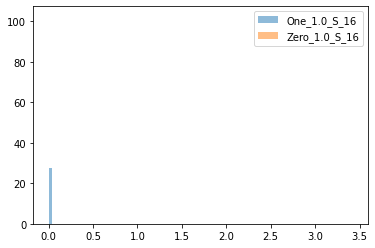

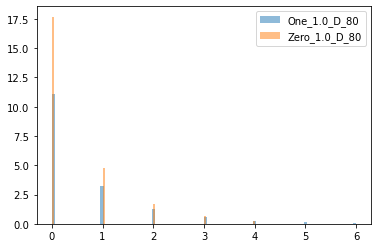

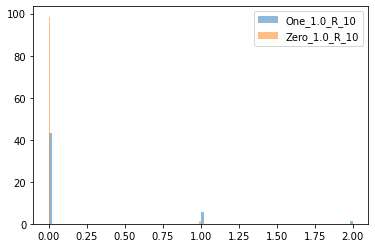

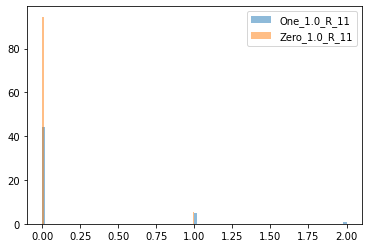

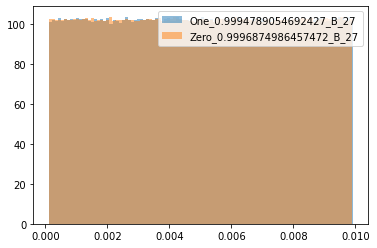

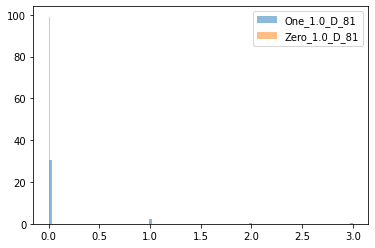

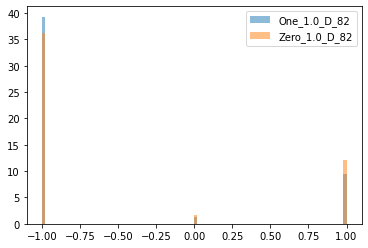

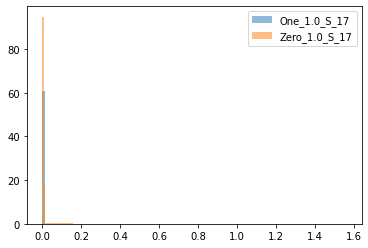

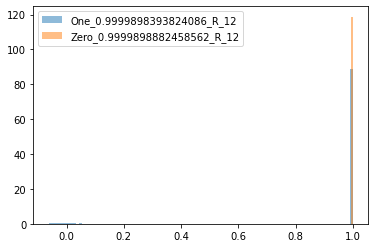

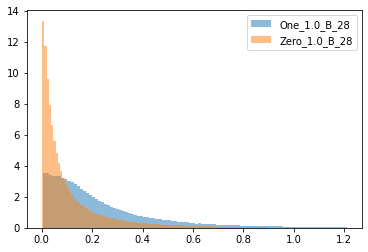

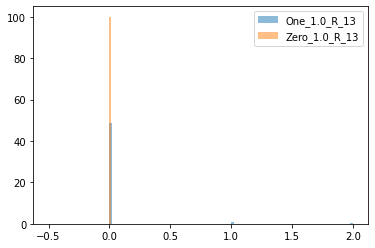

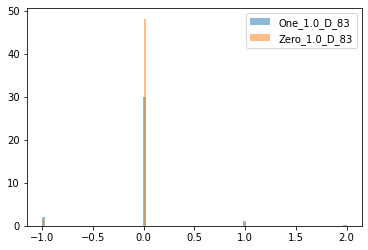

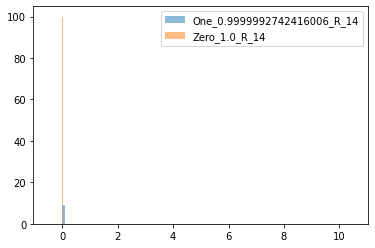

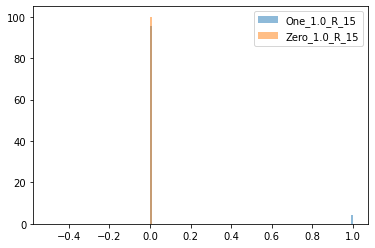

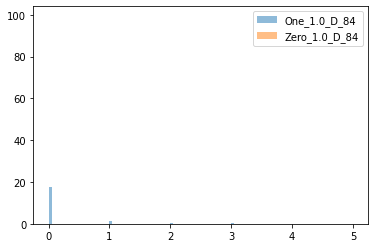

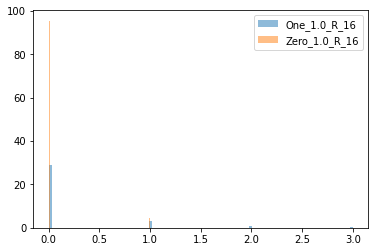

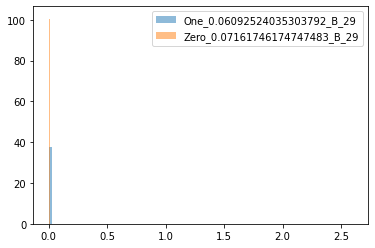

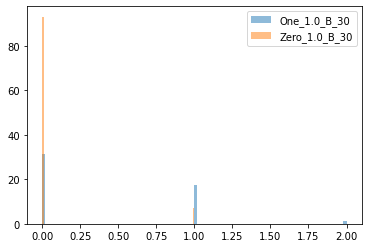

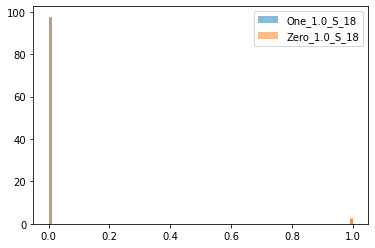

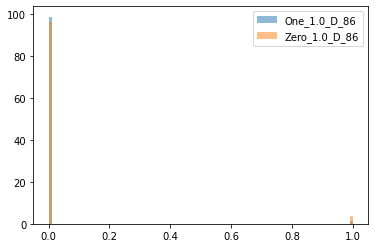

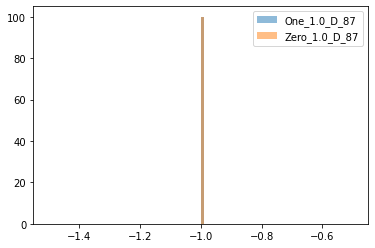

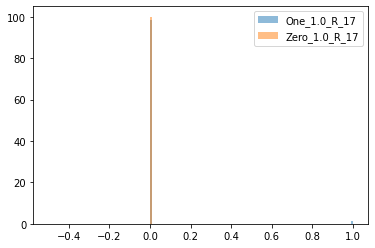

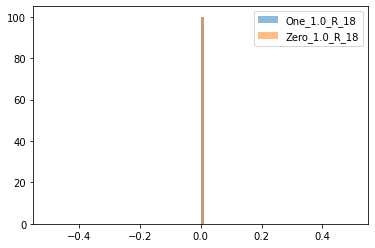

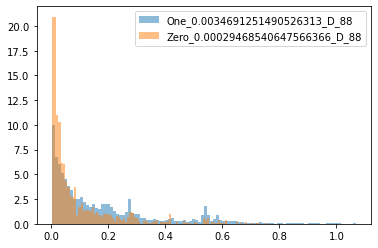

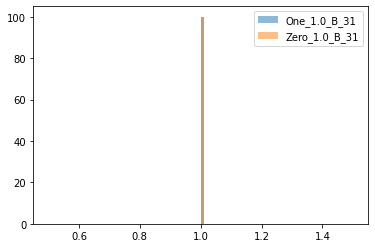

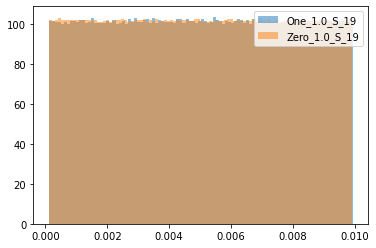

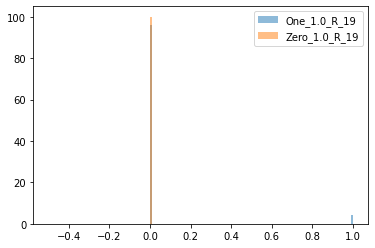

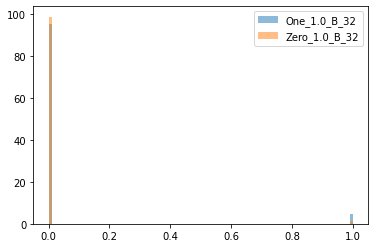

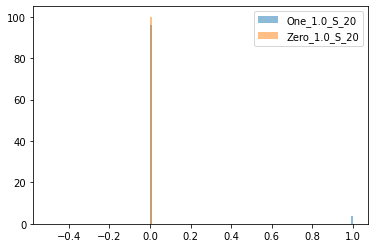

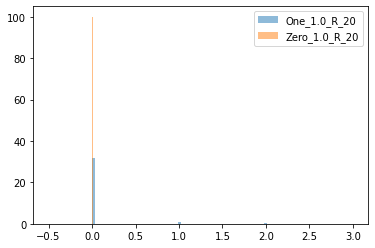

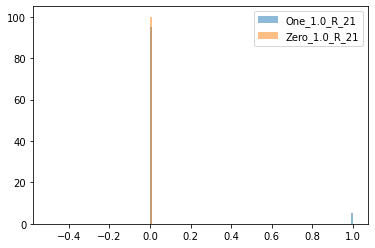

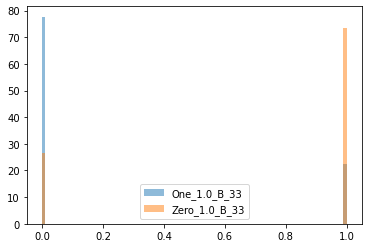

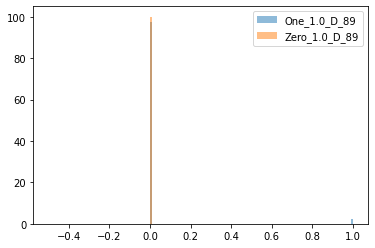

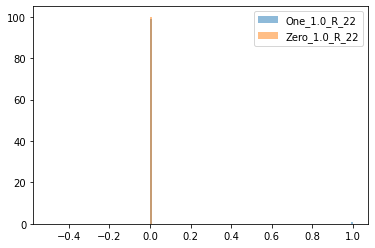

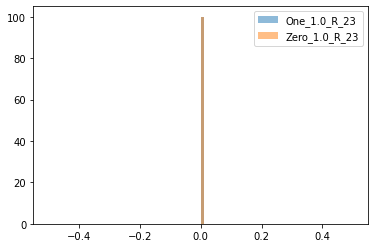

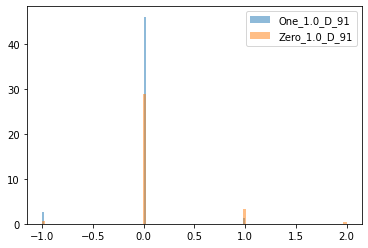

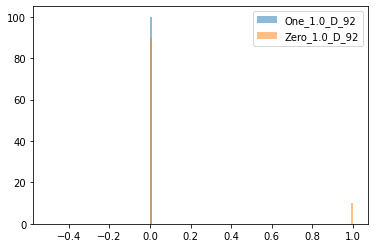

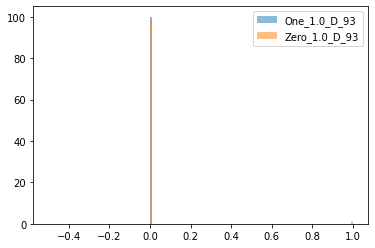

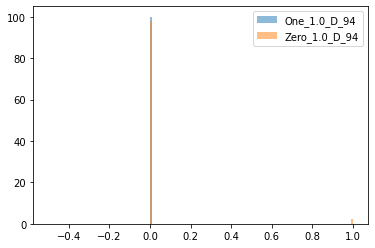

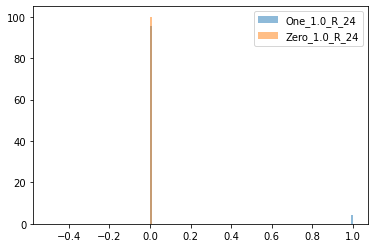

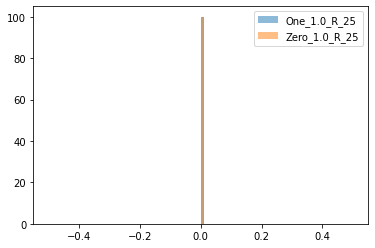

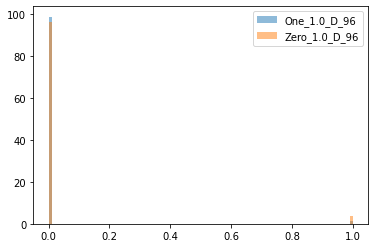

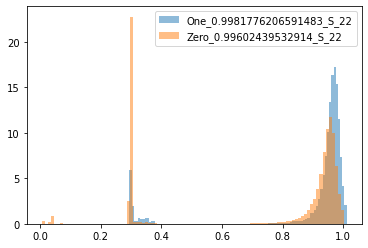

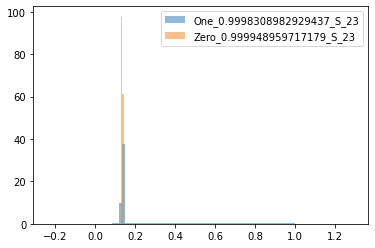

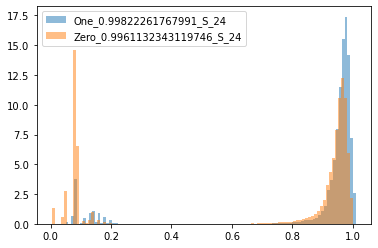

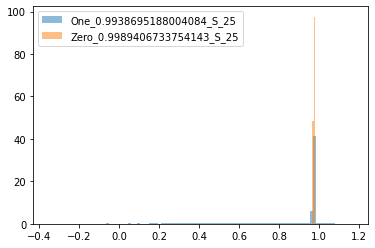

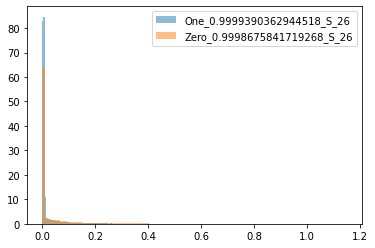

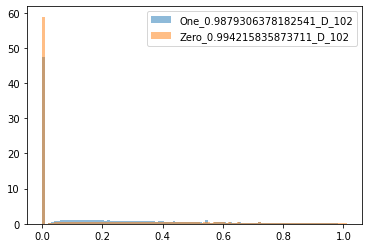

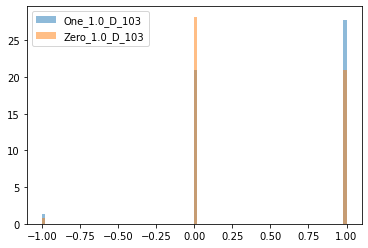

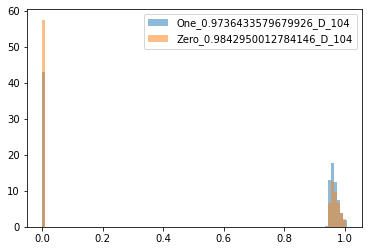

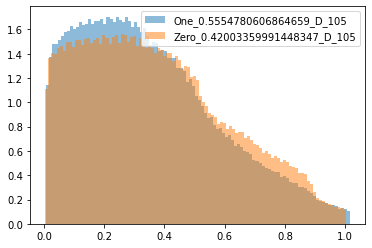

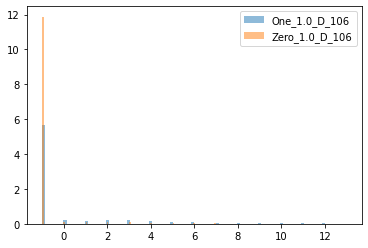

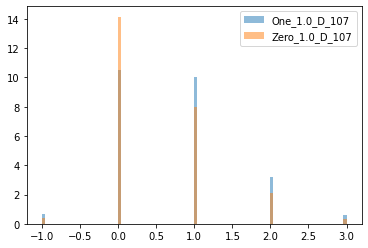

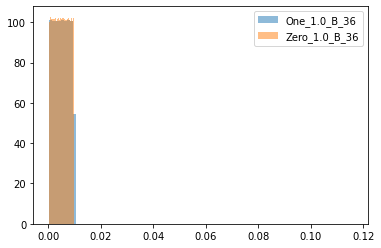

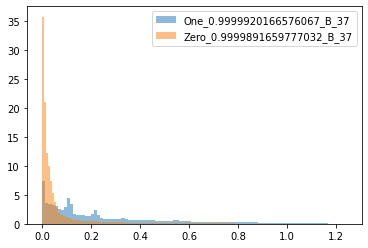

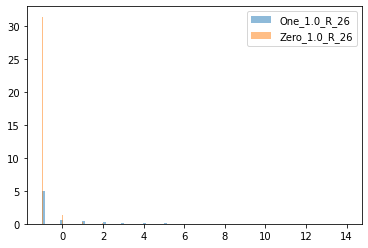

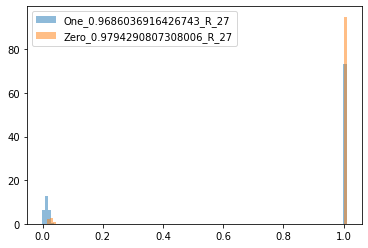

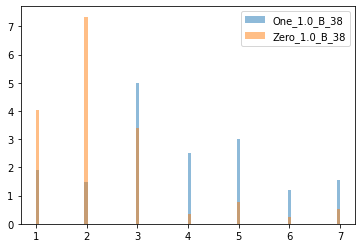

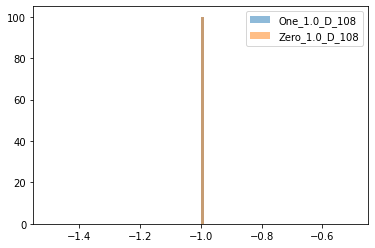

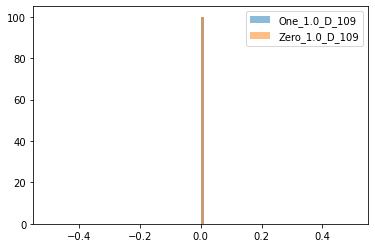

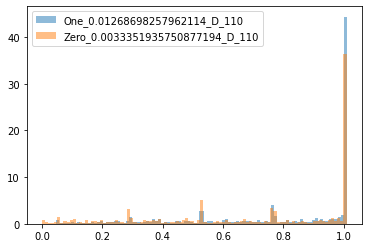

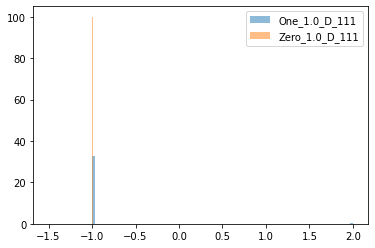

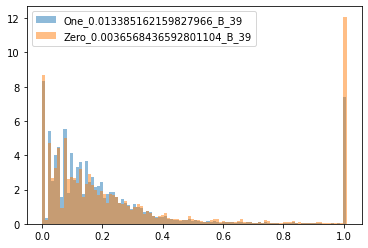

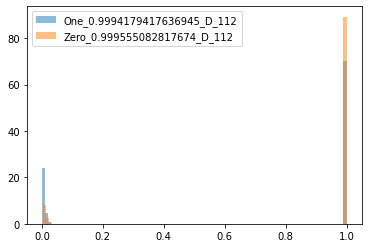

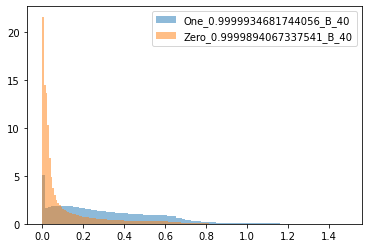

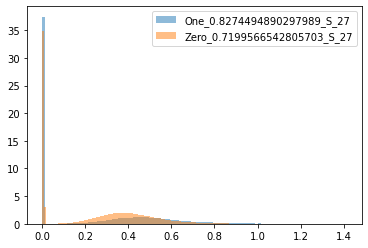

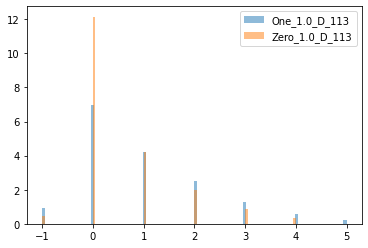

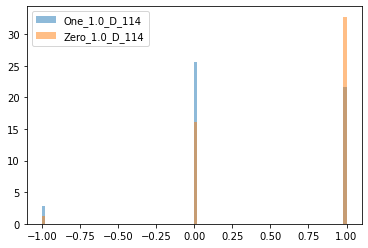

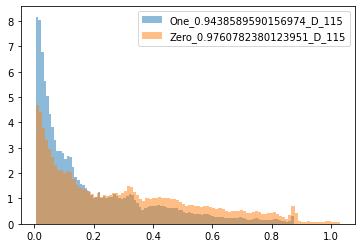

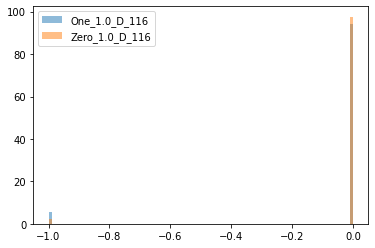

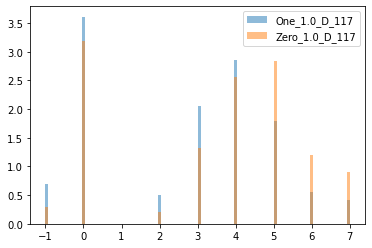

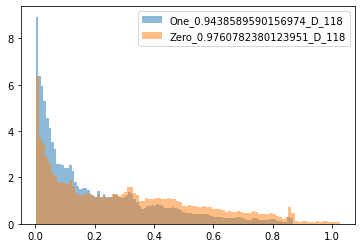

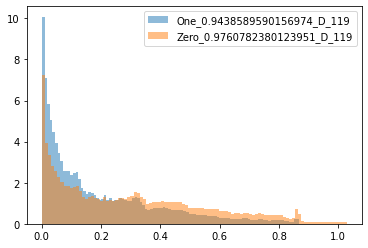

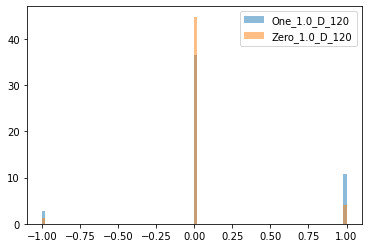

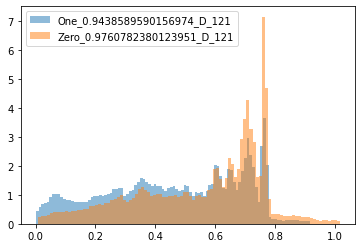

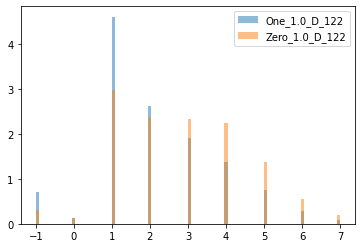

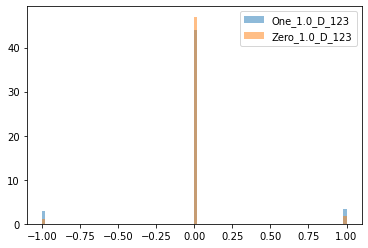

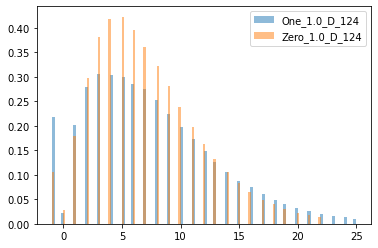

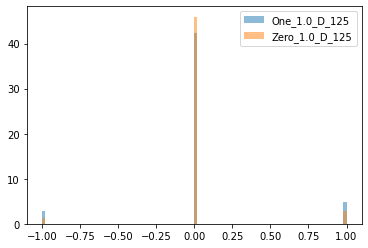

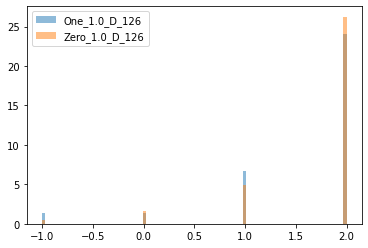

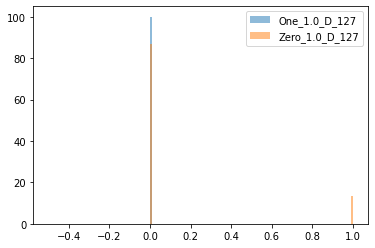

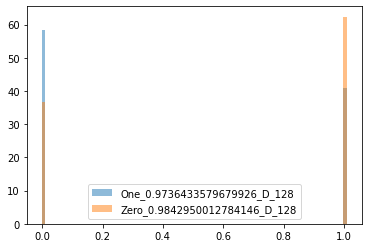

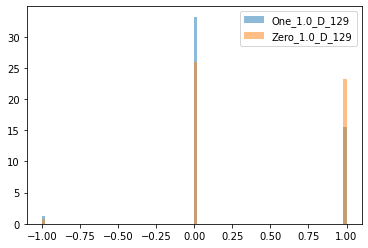

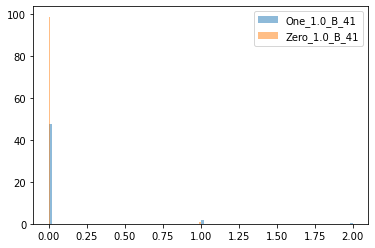

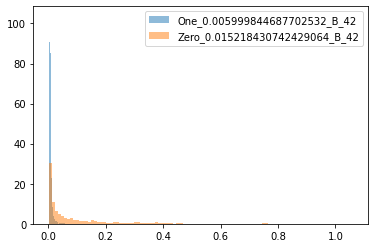

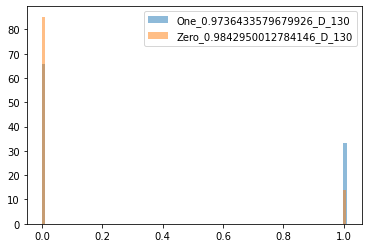

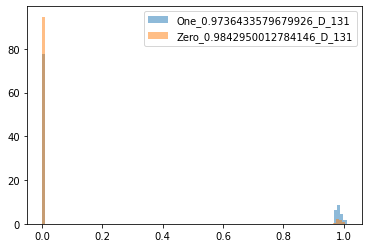

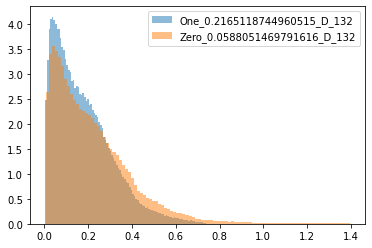

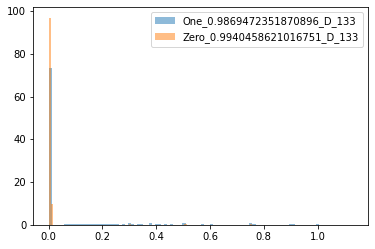

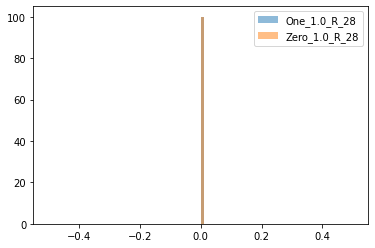

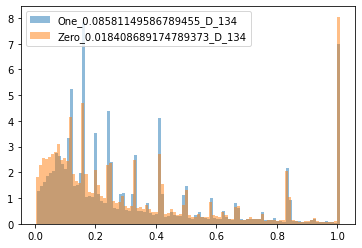

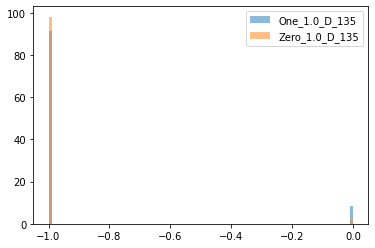

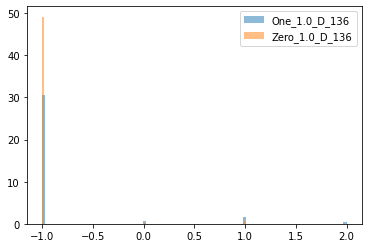

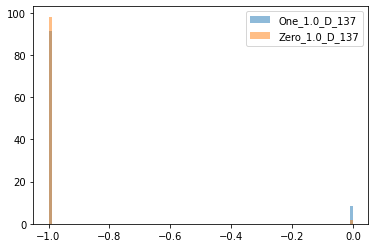

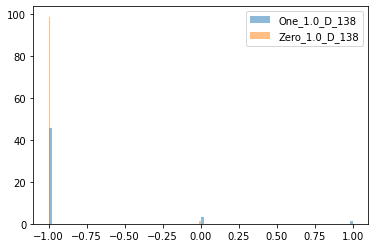

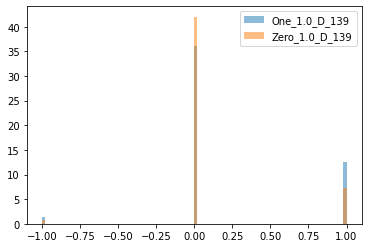

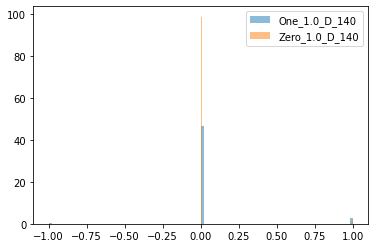

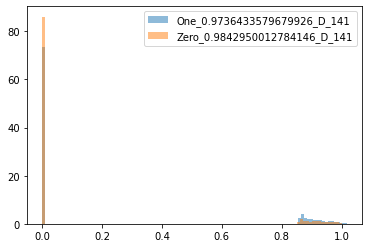

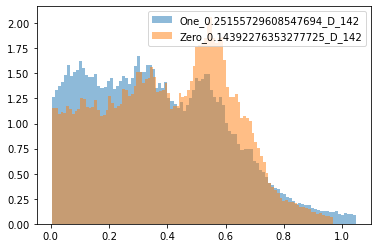

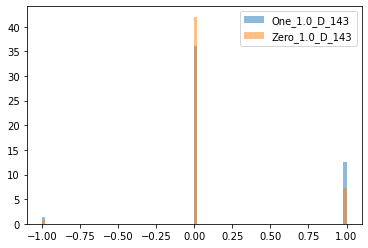

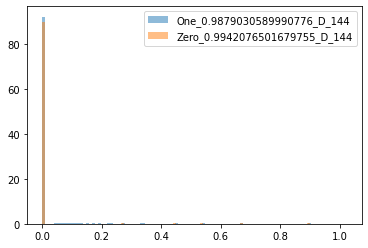

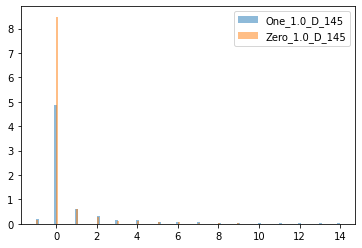

In [124]:
N0 = c0d.shape[0]
N1 = c1d.shape[0]
feat_dist = {}

for c in train_data.columns:
    if  train_data.dtypes[c] != object:
        d1 = c1d[c].dropna()
        q11 = d1.quantile(.01)
        q12 = d1.quantile(.99)
        hist1 = plt.hist(d1, range=[q11, q12], bins=100, label=f"One_{d1.shape[0]/N1}_{c}", density=True, alpha=0.5)
        feat_dist[c] = {1:hist1}
        d0 = c0d[c].dropna()
        q01 = d0.quantile(.01)
        q02 = d0.quantile(.99)
        hist0 = plt.hist(d0, range=[q01, q02], bins=100, label=f"Zero_{d0.shape[0]/N0}_{c}", density=True, alpha=0.5)
        feat_dist[c] = {0:hist0}
        feat_dist[c] = {"q99":np.maximum(q02, q12)}
        plt.legend()
        plt.show()


1.009979

In [108]:
man_feats = ["P_2", "B_1", "B_2", "R_1", "S_3", "D_41", "B_3", 
	"D_42", "D_43", "D_44", "B_4", "D_45", "B_5", "R_2", 
	"D_46", "D_47", "D_48", "D_49", "B_6", "B_7", "B_8", 
	"D_50", "D_51", 'B_9', "R_3", "D_52", "P_3", "B_10",
	"D_53", "S_5", "B_11", "S_6", "R_4", "S_7", "B_12", 
	"S_8", "D_55", "D_56", "D_58", "D_59", "D_60", "D_61",
	"S_11", "D_62", "D_64", "B_16", "B_17", "B_18", "B_19", 
	"B_20", "D_68", "B_22", "D_70", "S_15", "B_23", "D_74", 
	"D_75", "D_76", "D_78", "D_79", "B_28", "B_30", "B_33", 
	"S_22", "S_23", "S_24", "B_37", "R_26", "B_38", "B_40", 
	"D_124", "D_128", "D_129"]

In [43]:
for c in man_feats:
    train_data[c] = train_data[c]/ feat_dist[c]["q99"]


In [109]:
import copy
f = copy.deepcopy(man_feats)
f.append("customer_ID")
df = train_data[f]


# Train

In [85]:

import numpy as np
import pandas as pd
from sympy import im 
import torch 
import torch.nn as nn
import torch.nn.functional as F
from pd.nn.model import MLP

from pd.metric import amex_metric
from pd.data.loader import CustomerData, DataLoader
from pd.params import *

In [186]:
from torch.utils.data import Dataset


class CustomerData(Dataset):
    def __init__(self, data, cols, test_mode=False, train_labels=None):
        self.data = data
        self.test_mode = test_mode
        self.cat_cols = ""
        customer_indices = data["customer_ID"].reset_index().set_index("customer_ID").groupby('customer_ID').apply(lambda x : x.to_numpy().reshape(-1, )).to_dict()
        self.customer_ids =tuple(customer_indices)
        self.customer_indices = tuple(customer_indices.values())
        self.train_labels = train_labels
        self.data_columns = data.columns.to_list()
        self.cont_cols = cols

    def __len__(self):
        return len(self.customer_indices)

    def __getitem__(self, index):
        customer_data_indices = self.customer_indices[index]
        skiprows = customer_data_indices[0] + 1
        nrows = customer_data_indices[-1] - customer_data_indices[0] + 1
        customer_data = self.data.iloc[skiprows: skiprows+nrows]
        customer_id = customer_data.customer_ID.iloc[0]
                
        s = customer_cont_data = customer_data[self.cont_cols].values
        cont_feat = np.concatenate((np.nanmax(s, axis=0),
                    np.nanmin(s, axis=0),
                    np.nanmean(s, axis=0),),
                    axis=0).reshape(-1, 3)
                    #np.nanmedian(s, axis=0),
                    #np.nanstd(s, axis=0)), 
        cont_feat = np.nan_to_num(cont_feat, nan=0)
        customer_cont_tensor_data = torch.as_tensor(cont_feat, dtype=torch.float32)
        feat = customer_cont_tensor_data
        if self.test_mode:
            return feat, index
        else:
            customer_label = torch.as_tensor(self.train_labels.loc[customer_id].values, dtype=torch.float32)
            return feat, customer_label

In [187]:
train_dataset = CustomerData(df, man_feats, train_labels=train_labels.set_index("customer_ID"),)

In [188]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)


In [ ]:
s = train_dataset[1][0]
s.shape 

torch.Size([73, 5])

In [191]:
class Conv(nn.Module):

    def __init__(self, hidden_dim=64, output_dim=1, ):
        super(Conv, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=10, kernel_size=3, )
        self.conv3 = nn.Conv1d(in_channels=10, out_channels=1, kernel_size=3, )
        self.fc1 = nn.Linear(in_features=69, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=1)
    def forward(self, h):
        h = F.selu(self.conv1(h))
        h = F.selu(self.conv3(h))
        h = F.selu(self.fc1(h))
        return torch.sigmoid(self.fc2(h)).squeeze(-1)



In [192]:
model = Conv()
optimizer = torch.optim.Adam(model.parameters(),)
criterion = torch.nn.BCELoss()

for epoch in range(15): 
    for cont_feat, clabel in train_loader:
        #feat = torch.cat((cont_feat, cat_feat), dim=-1)
        feat = cont_feat

        pred = model(feat.transpose(-1, -2))
        #weight = clabel.clone()
        #weight[weight==1] = 4
        #criterion.weight = weight
        loss = criterion(pred, clabel)
        
        # Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(epoch, loss.item(), amex_metric(clabel.detach().numpy(), pred.detach().numpy()))


0 0.6270095109939575 0.1427659722558896
0 0.6125272512435913 0.23364764704055918
0 0.5977030992507935 0.3372885266558768
0 0.5865134000778198 0.3948591351872609
0 0.5699159502983093 0.44111297531024274
0 0.5567610859870911 0.4747266520426454
0 0.5441862344741821 0.501082762057149
0 0.5351226925849915 0.5039614098963804
0 0.5223276019096375 0.5071908073684663
0 0.5178635120391846 0.5254032050191887
0 0.5169079899787903 0.5145925896697118
0 0.5024546384811401 0.520208582786327
0 0.49747881293296814 0.5207598762435355
0 0.49049094319343567 0.5211607701297258
0 0.48768216371536255 0.5440904414235795
0 0.47694963216781616 0.5484558599223228
0 0.4786684811115265 0.521312522203103
0 0.4701777994632721 0.5362387992498893
0 0.45884934067726135 0.5361231434709421
0 0.45183923840522766 0.530347818691656
0 0.4398961663246155 0.5546991515336039
0 0.43637385964393616 0.5517907558591625
0 0.4297458231449127 0.5458703654928517
0 0.4228929579257965 0.5381870057867454
0 0.4179171025753021 0.559722242034

KeyboardInterrupt: 

In [157]:
model = Conv()
red = model(feat.transpose(-1, 1))

In [164]:
red.squeeze(-1).shape

torch.Size([15000, 1])